## The data was extracted from serpapi which basically do Google Map search to extract the information.

# Importing Required Libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [14]:
!pip install serpapi

In [15]:
!pip install google-search-results

In [16]:
from serpapi import GoogleSearch
from urllib.parse import urlsplit, parse_qsl
import json

# Extracting the data using SerpApi

In [17]:
params = {
    'api_key': '93c4354226b47f8bf6ebb42ca269006bf0347a66f0712a653126c2aa59c14833',
    'engine': 'google_maps',
    'q': 'food truck',
    'll': '@40.7455096,-74.0083012,10.1z',
    'type': 'search',
    'hl': 'en',
    'start': 0,
}

search = GoogleSearch(params)

local_results = []

while True:
    results = search.get_dict()

    if 'next' in results.get('serpapi_pagination', {}):
        search.params_dict.update(dict(parse_qsl(urlsplit(results.get('serpapi_pagination', {}).get('next')).query)))
    else:
        break

    local_results.extend(results['local_results'])

In [18]:
df = pd.DataFrame(local_results)

In [19]:
df = df[['title', 'rating', 'gps_coordinates', 'address', 'types', 'operating_hours']]

In [20]:
df.head(2)

,title,rating,gps_coordinates,address,types,operating_hours
0,2 Much Sauce Food Truck,4.4,"{'latitude': 40.646096899999996, 'longitude': ...","1719 E 2nd St, Scotch Plains, NJ 07076","[Restaurant, Chicken restaurant]","{'monday': 'Closed', 'tuesday': '12–10 PM', 'w..."
1,Lil Zeus Food Truck,4.7,"{'latitude': 40.7599732, 'longitude': -73.9811...","112 W 50th St, New York, NY 10020",[Greek restaurant],"{'monday': '11 AM–2:30 PM', 'tuesday': '11 AM–..."


# Data Cleaning/Formatting

In [21]:
def extract_coordinates(coords):
    return coords['latitude'], coords['longitude']

df[['latitude', 'longitude']] = df['gps_coordinates'].apply(extract_coordinates).apply(pd.Series)
df = df.drop(columns=['gps_coordinates'])

In [22]:
def extract_cuisine_type(types_list):
    cuisine_keywords = [
        'Italian', 'Chinese', 'Indian', 'Japanese', 'French', 'Mexican',
        'Thai', 'Mediterranean', 'Middle Eastern', 'Korean', 'Vietnamese',
        'American', 'Greek', 'Spanish', 'Ethiopian', 'Dominican', 'Puerto Rican',
        'Fast Food', 'Chicken', 'African', 'Cafe', 'Halal', 'Taco', 'venezuelan', 'jamaican', 'Pizza', 'filipino'
    ]

    for keyword in cuisine_keywords:
        if any(keyword.lower() in cur_type.lower() for cur_type in types_list):
            return keyword

    return None

df['specific_type'] = df['types'].apply(extract_cuisine_type)

In [23]:
dish_to_cuisine = {
    'Pizza': 'Fast Food',
    'Taco': 'Mexican'
}

def map_dish_to_cuisine(dish):
    if dish not in dish_to_cuisine:return dish
    return dish_to_cuisine.get(dish)

df['specific_type'] = df['specific_type'].apply(map_dish_to_cuisine)

In [24]:
df = df[~df['specific_type'].isna()]
df = df.drop(columns=['types'])

# Data Visualization

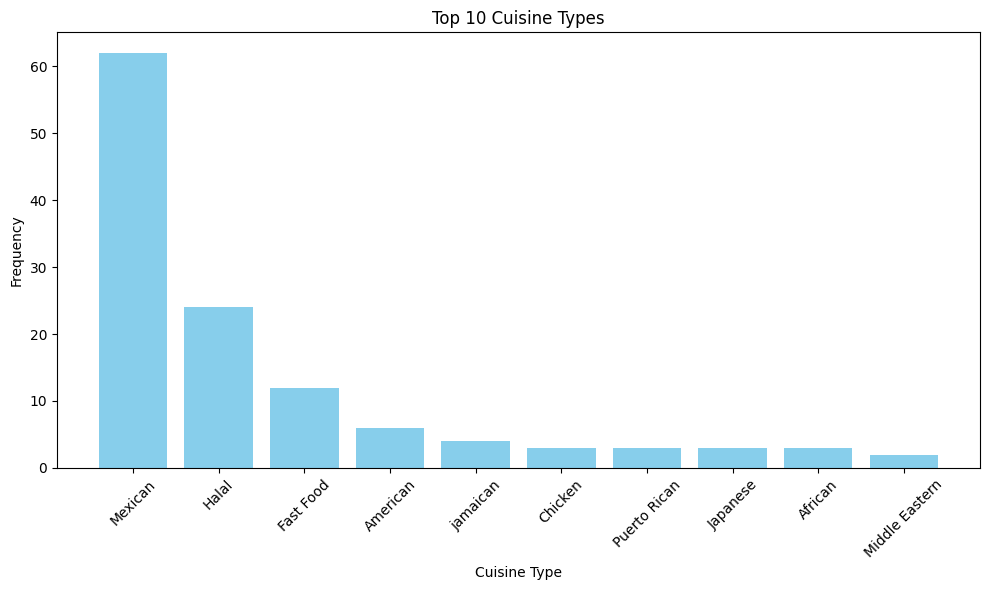

In [25]:
cuisine_counts = df['specific_type'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
plt.bar(cuisine_counts.index, cuisine_counts.values, color='skyblue')
plt.xlabel('Cuisine Type')
plt.ylabel('Frequency')
plt.title('Top 10 Cuisine Types')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Insights from above plot:** We can see that in New York City, there are more Mexican food trucks compared to any other type of cuisine. Halal and Fast food come next in popularity. It seems like New Yorkers really enjoy Mexican food!

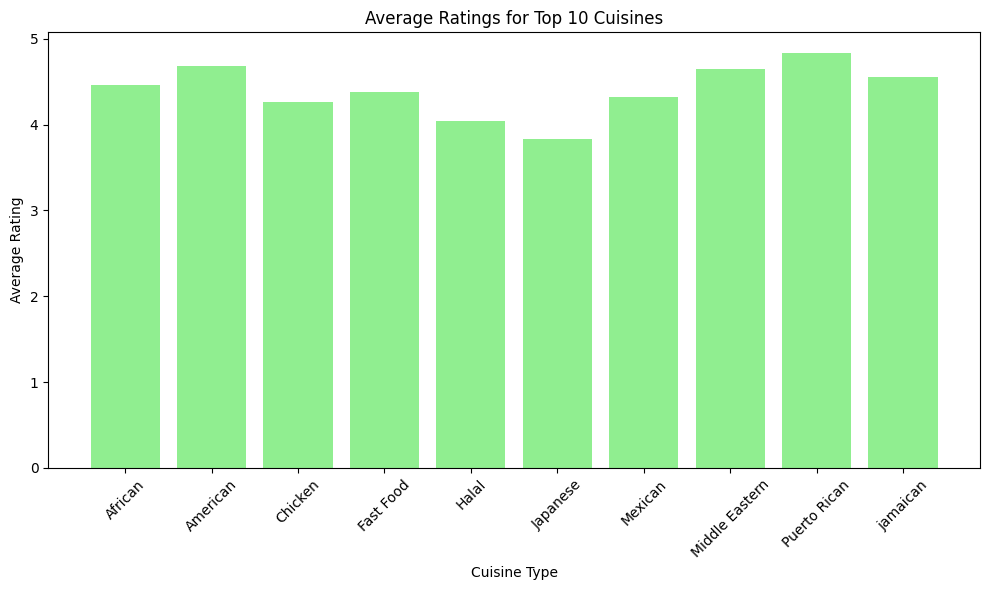

In [26]:
top_cuisines = df['specific_type'].value_counts().nlargest(10).index
filtered_df = df[df['specific_type'].isin(top_cuisines)]

average_ratings = filtered_df.groupby('specific_type')['rating'].mean()

plt.figure(figsize=(10, 6))
plt.bar(average_ratings.index, average_ratings.values, color='lightgreen')
plt.xlabel('Cuisine Type')
plt.ylabel('Average Rating')
plt.title('Average Ratings for Top 10 Cuisines')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**The provided graph illustrates** the average ratings for the top 10 cuisine types based on their frequency of occurrence. It is noteworthy that American and Puerto Rican cuisines have garnered the highest average ratings, while Halal and Italian cuisines exhibit the lowest average ratings. This data, in conjunction with the information presented in a preceding graph, leads to the conclusion that despite the relatively limited number of American and Puerto Rican food trucks, they consistently provide exceptionally high-quality offerings.

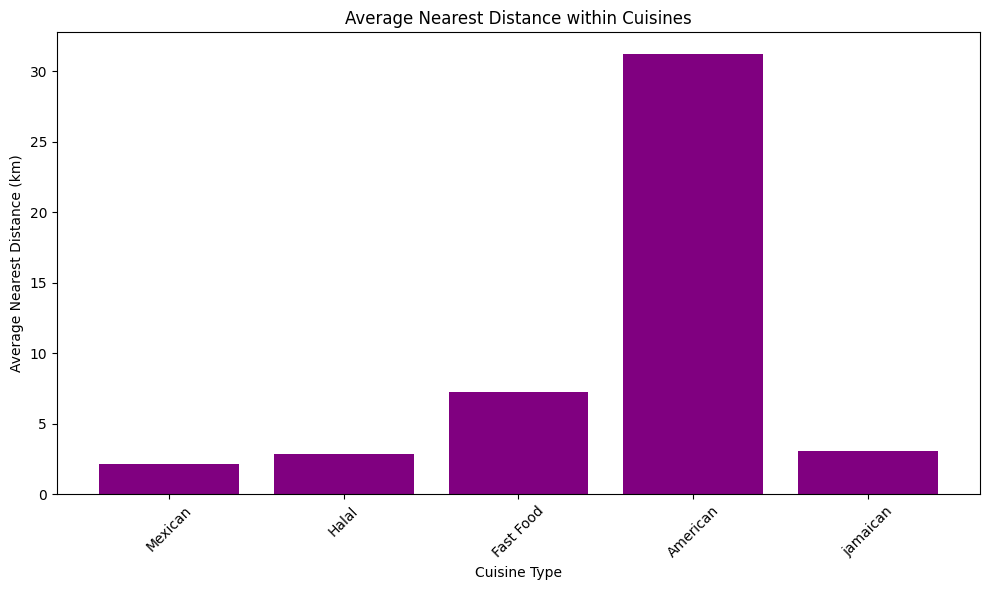

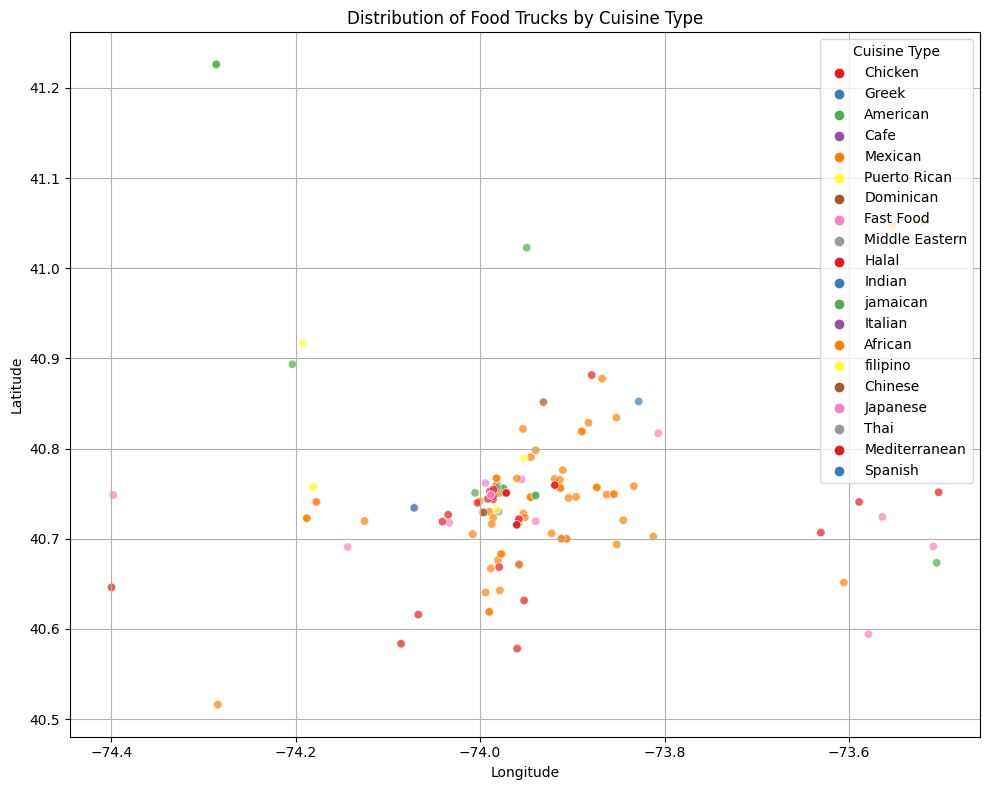

In [27]:

top_cuisines = df['specific_type'].value_counts().nlargest(5).index
filtered_df = df[df['specific_type'].isin(top_cuisines)]

def haversine(lat1, lon1, lat2, lon2):
    R = 6371

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    distance = R * c
    return distance

average_distances = {}

for cuisine in top_cuisines:
    total_distance = 0
    total_restaurants = 0

    cuisine_df = filtered_df[filtered_df['specific_type'] == cuisine]

    for _, row1 in cuisine_df.iterrows():
        nearest_distance = float('inf')

        for _, row2 in cuisine_df.iterrows():
            if row1['latitude'] != row2['latitude'] and row1['longitude'] != row2['longitude']:
                distance = haversine(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])
                if distance < nearest_distance:
                    nearest_distance = distance

        if nearest_distance != float('inf'):
            total_distance += nearest_distance
            total_restaurants += 1

    average_distances[cuisine] = total_distance / total_restaurants if total_restaurants > 0 else 0

plt.figure(figsize=(10, 6))
plt.bar(average_distances.keys(), average_distances.values(), color='purple')
plt.xlabel('Cuisine Type')
plt.ylabel('Average Nearest Distance (km)')
plt.title('Average Nearest Distance within Cuisines')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='specific_type', data=df, palette='Set1', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Food Trucks by Cuisine Type')
plt.legend(title='Cuisine Type')
plt.grid(True)
plt.tight_layout()

plt.show()

**Insights from above two graph**: The depicted graphs indicate a notable concentration of food trucks within the geographic coordinates of approximately 40.6 to 40.8 latitude and -74.2 to -73.8 longitude. Additionally, it is noteworthy that within a radius of 2.5 kilometers, there is a substantial presence of both Mexican and Halal cuisine offerings. In contrast, American cuisine food trucks are distributed at a notably larger average interval of approximately 35 kilometers from one another.

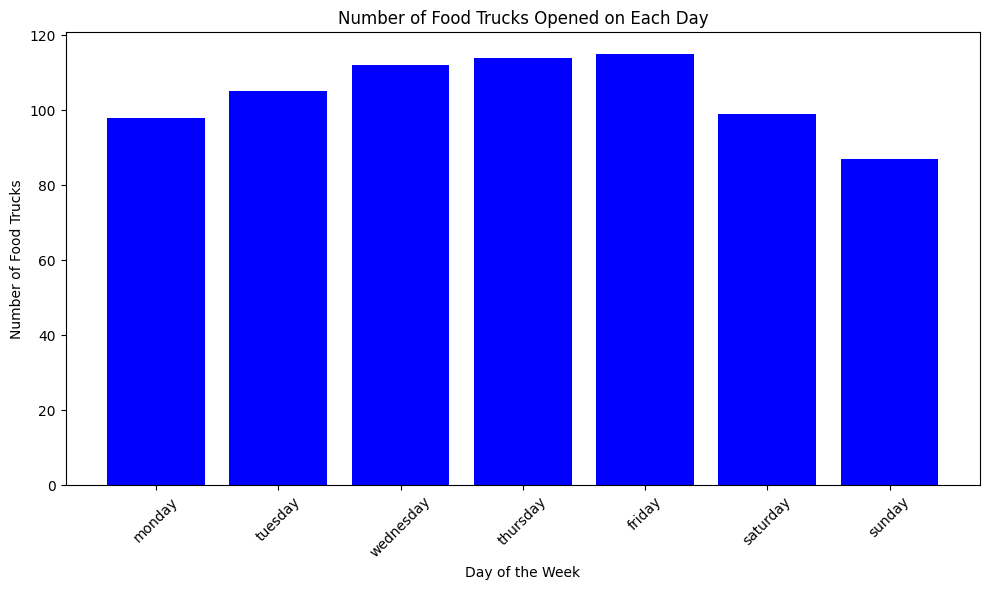

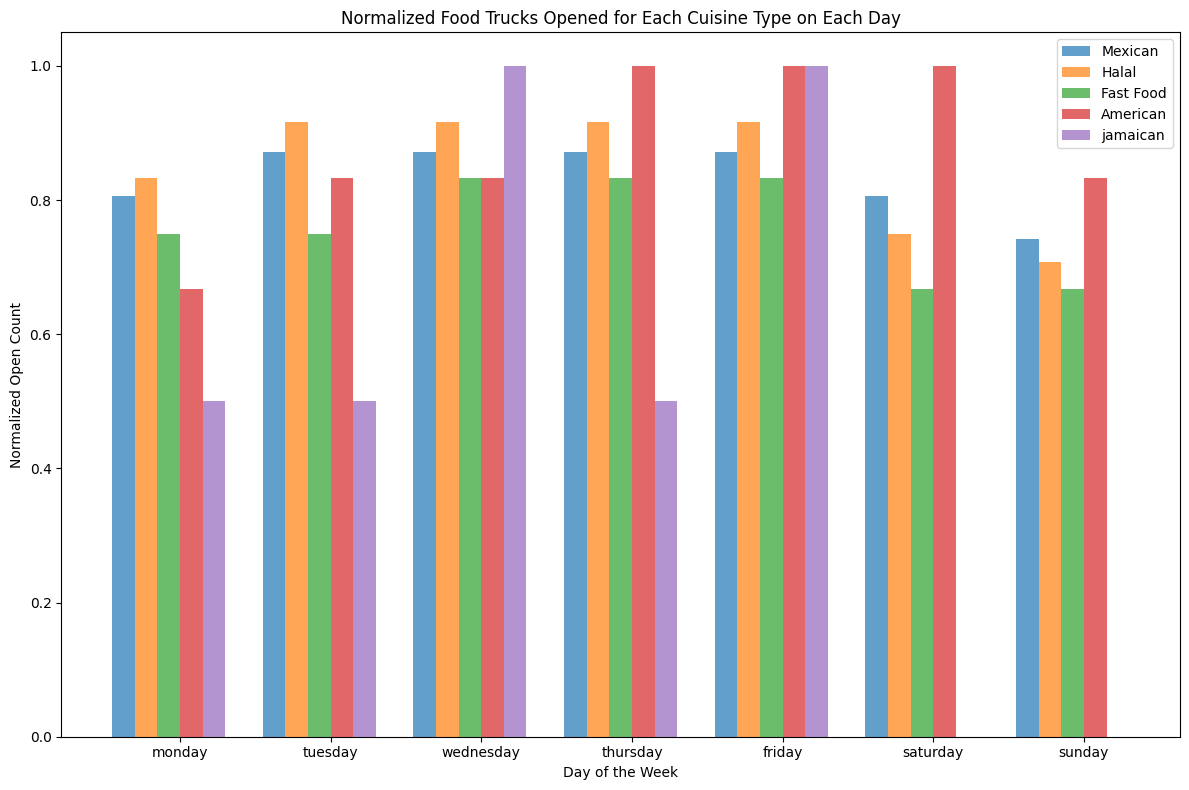

In [28]:
all_days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

count_dict = dict.fromkeys(all_days,0)
total = 0

for cur_dict in df['operating_hours']:

  if cur_dict is None or type(cur_dict)!=dict:continue

  total += 1

  for day in all_days:
    if cur_dict[day] != 'Closed':
      count_dict[day] += 1


plt.figure(figsize=(10, 6))
plt.bar(count_dict.keys(), count_dict.values(), color='blue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Food Trucks')
plt.title('Number of Food Trucks Opened on Each Day')
plt.xticks(rotation=45)
plt.tight_layout()


import numpy as np

top_cuisines = df['specific_type'].value_counts().nlargest(5).index
filtered_df = df[df['specific_type'].isin(top_cuisines)]

all_days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
cuisine_open_counts = {cuisine: dict.fromkeys(all_days, 0) for cuisine in top_cuisines}

cuisine_counts = filtered_df['specific_type'].value_counts()

for idx, cur_dict in enumerate(filtered_df['operating_hours']):
    if cur_dict is None or type(cur_dict) != dict: continue

    cuisine_type = filtered_df.iloc[idx]['specific_type']

    for day in all_days:
        if cur_dict.get(day) != 'Closed':
            cuisine_open_counts[cuisine_type][day] += 1

for cuisine, counts in cuisine_open_counts.items():
    total_count = cuisine_counts[cuisine]
    for day in all_days:
        counts[day] = counts[day] / total_count if total_count > 0 else 0

days_idx = np.arange(len(all_days))
bar_width = 0.15
opacity = 0.7

plt.figure(figsize=(12, 8))

for i, (cuisine, counts) in enumerate(cuisine_open_counts.items()):
    plt.bar(days_idx + i*bar_width, list(counts.values()), bar_width,
            alpha=opacity, label=cuisine)

plt.xlabel('Day of the Week')
plt.ylabel('Normalized Open Count')
plt.title('Normalized Food Trucks Opened for Each Cuisine Type on Each Day')
plt.xticks(days_idx + bar_width * 2.5, all_days)
plt.legend()
plt.tight_layout()

plt.show()


Insights from above graph: Surprisingly, there are more food trucks open on weekdays than on weekends. This suggests that people might not be as interested in food trucks during the weekend. Specifically, you'll find more Jamaican food trucks on Wednesdays and Fridays. And because there are a lot of Mexican food trucks, you can easily find Mexican food any day of the week.

# Saving the data

In [31]:
df = df.rename(columns={'specific_type':'Cuisine'})

In [32]:
df.to_csv('Extracted_data.csv')

# Getting the Weekend Plan

In [58]:
# Step 1: Filter open restaurants
open_restaurants = df[df['operating_hours'].apply(lambda x: type(x) is dict and x['saturday']!='Closed' and x['sunday']!='Closed')]

# Step 2: Sort by cuisine, rating
sorted_restaurants = open_restaurants.sort_values(by=['Cuisine', 'rating'], ascending=[True, False])

restaurant_to_visit = sorted_restaurants.groupby(by='Cuisine').first().sort_values(by=['rating'],ascending=[False]).reset_index().head(6)

In [68]:
restaurant_to_visit.loc[:2, 'Day'] = 'Saturday'
restaurant_to_visit.loc[3:5, 'Day'] = 'Sunday'

In [72]:
restaurant_to_visit

,Cuisine,title,rating,address,operating_hours,latitude,longitude,Day
0,American,Mystical Cuisine Halal Food Truck,5.0,"New York, NY 10001","{'monday': 'Open 24 hours', 'tuesday': 'Open 2...",40.750870,-74.005557,Saturday
1,Fast Food,Seraphic Saba Food Truck,5.0,"1980 Hempstead Bethpage Turnpike, East Meadow,...","{'monday': '4–10:30 PM', 'tuesday': 'Closed', ...",40.724181,-73.563740,Saturday
2,Halal,Roma’s Hot Dogs & Halal Food Truck,5.0,"Uniondale, NY 11590","{'monday': 'Closed', 'tuesday': 'Closed', 'wed...",40.740799,-73.588935,Saturday
3,Mexican,Mexiflip Taco Truck,5.0,"345-381 Dr Martin Luther King Jr Blvd, Newark,...","{'monday': '10:30 AM–8 PM', 'tuesday': '10:30 ...",40.740768,-74.177329,Sunday
4,Middle Eastern,King Of Falafel & Shawarma Food Truck,5.0,"229 Bedford Ave, Brooklyn, NY 11211","{'monday': 'Closed', 'tuesday': 'Closed', 'wed...",40.716217,-73.959331,Sunday
5,Dominican,Punto Final Food Truck,4.9,"565 W 185th St, New York, NY 10033","{'monday': 'Closed', 'tuesday': 'Closed', 'wed...",40.851513,-73.931312,Sunday


In [73]:
restaurant_to_visit.to_csv('Plan.csv')

**Now I will add manually the travel distance, transportation type, travel time, and then map screenshot due to problem in accessing the API. You will find the final plan.csv in the same folder as this file is in.**